In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

In [27]:
#events_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/event_data_train.zip')
submissions_data = pd.read_csv('https://stepik.org/media/attachments/course/4852/submissions_data_train.zip')

In [24]:
sns.set(rc={'figure.figsize': (9, 6)})

In [16]:
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')

In [18]:
events_data['day'] = events_data.date.dt.date

In [19]:
events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


<AxesSubplot:xlabel='day'>

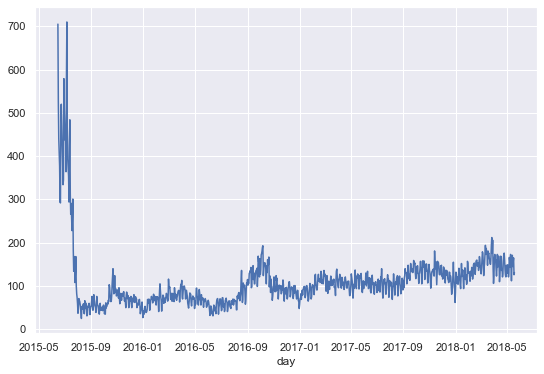

In [25]:
events_data.groupby('day') \
    .user_id.nunique().plot()

In [64]:
user_event_data = events_data.pivot_table(index='user_id',
                        columns='action',
                        values='step_id',
                        aggfunc='count',
                        fill_value=0).reset_index()

In [65]:
user_event_data.head()

action,user_id,discovered,passed,started_attempt,viewed
0,1,1,0,0,1
1,2,9,9,2,10
2,3,91,87,30,192
3,5,11,11,4,12
4,7,1,1,0,1


In [29]:
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')
submissions_data['day'] = submissions_data.date.dt.date

In [41]:
submissions_data.head()

,step_id,timestamp,submission_status,user_id,date,day
0,31971,1434349275,correct,15853,2015-06-15 06:21:15,2015-06-15
1,31972,1434348300,correct,15853,2015-06-15 06:05:00,2015-06-15
2,31972,1478852149,wrong,15853,2016-11-11 08:15:49,2016-11-11
3,31972,1478852164,correct,15853,2016-11-11 08:16:04,2016-11-11
4,31976,1434348123,wrong,15853,2015-06-15 06:02:03,2015-06-15


In [32]:
users_scores = submissions_data.pivot_table(index='user_id',
                        columns='submission_status',
                        values='step_id',
                        aggfunc='count',
                        fill_value=0).reset_index()

In [33]:
users_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [40]:
pivot_event[pivot_event['discovered'] == pivot_event['discovered'].max()]

action,user_id,discovered,passed,started_attempt,viewed
13,22,198,198,89,492
18,30,198,198,150,512
22,34,198,195,92,1013
26,39,198,198,88,1160
59,80,198,198,80,393
...,...,...,...,...,...
19102,26610,198,198,101,2012
19104,26613,198,193,89,670
19108,26619,198,198,110,807
19152,26676,198,196,112,1026


In [42]:
users_scores[users_scores['correct'] == users_scores['correct'].max()]

submission_status,user_id,correct,wrong
439,1046,421,513


In [48]:
gap_data = events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day']) \
           .groupby('user_id')['timestamp'].apply(list).apply(np.diff).values

In [49]:
gap_data = pd.Series(np.concatenate(gap_data, axis=0))

In [52]:
gap_data = gap_data / (24*60*60)

<AxesSubplot:>

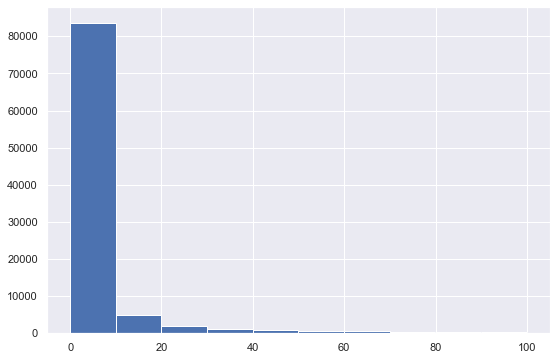

In [55]:
gap_data[gap_data < 100].hist()

In [56]:
gap_data.quantile(0.90)

18.325995370370403

In [57]:
user_data = events_data.groupby('user_id', as_index=False) \
    .agg({'timestamp': 'max'}).rename(columns={'timestamp': 'last_timestamp'})

In [59]:
now = 1526772811
drop_out_treshold = 2592000

In [60]:
user_data['is_gone_user'] = (now - user_data.last_timestamp) > drop_out_treshold

In [62]:
user_data = user_data.merge(users_scores, on='user_id', how='outer').fillna(0)

In [63]:
user_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong
0,1,1472827464,True,0.0,0.0
1,2,1519226966,True,2.0,0.0
2,3,1444581588,True,29.0,23.0
3,5,1499859939,True,2.0,2.0
4,7,1521634660,True,0.0,0.0


In [66]:
user_data = user_data.merge(user_event_data, how='outer')

In [68]:
user_days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()

In [70]:
user_data = user_data.merge(user_days, how='outer')

In [73]:
user_data['passed_course'] = user_data.passed > 170

In [75]:
user_data.groupby('passed_course').count()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
passed_course,,,,,,,,,,
False,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809
True,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425
